In [1]:
import pandas as pd
import numpy as np
from math import sqrt, log, sin, cos, atan2, radians
from timeit import default_timer as timer

In [2]:
path_to_demand = r".\data\demand.pkl"
path_to_centers = r".\data\centers.pkl"

In [3]:
demand = pd.read_pickle(path_to_demand)

In [4]:
vehicle_speed = { # in km/min
    'bicycle': 0.0497,
    'moped':  (0.1117 + 0.0497)/2,# we do not have data on mopeds, but estimate
                                  # that their speed is between biycles and cars
    'car': 0.1117,
}
vehicle_speed['moped']

0.0807

In [5]:
vehicle_profit_min = { # euro / min
    'bicycle': 0.1 / 3,
    'moped': 0.19,
    'car': 0.29,
}
vehicle_profit_km = {key: p_m/vehicle_speed[key] for key,p_m in vehicle_profit_min.items() }
vehicle_profit_km

{'bicycle': 0.670690811535882,
 'moped': 2.354399008674102,
 'car': 2.596239928379588}

In [6]:
relocation_driver_salary = 14 # euro/hour
vehicle_rel_at_once = { # relocations at once, e.g. in a truck for moped/biycles
    'bicycle': 20,
    'moped': 10,
    'car': 1,
}
vehicle_cost_min = {key: (relocation_driver_salary / 60 / rel_at_once) for key, rel_at_once in vehicle_rel_at_once.items()}
vehicle_cost_min

{'bicycle': 0.011666666666666667,
 'moped': 0.023333333333333334,
 'car': 0.23333333333333334}

In [7]:
vehicle_cost_km = {key: c_m/vehicle_speed[key] for key,c_m in vehicle_cost_min.items() }
vehicle_cost_km

{'bicycle': 0.2347417840375587,
 'moped': 0.2891367203634862,
 'car': 2.0889286780065652}

In [8]:
n_regions = pd.concat([demand['region_start'],demand['region_end']]).max() + 1
region_size = 2.5

vehicle_parking_cost = { #eur/2h
    'car': 2,
    'moped': 0.4,
    'bicycle': 0.1,
}

vehicle_maximum_distance_cap = {
    'bicycle': 2,
    'moped': 8,
    'car': 100,
} # km

# The will later try different vehicle fleet capacities
# This is the initial setting, where we provide detailed information about the solution
vehicle_fleet_capacity = {
    'bicycle': 500,
    'moped': 250,
    'car': 250,
} # km
vehicle_classes = ['bicycle', 'moped', 'car']

number_starting_vehicles = 100

To calculate profit and cost, we need to approximate the distances of trips.  
For one-way trips between two distinct regions we will calculate the linear distance between the centers of the regions.  
For round trips this approach will perform poorly, because then all round trips would have a distance of zero, which would also lead to a calculated profit of zero.  
Therefore we calculate the average distance of two points in a square with length 1 and then multiply it by the length of our regions.
See this [video](https://www.youtube.com/watch?v=i4VqXRRXi68) for explanation on how we got the formula.
For one-way trips we will one-way trips we will approximate the average distance between two regions with the distance of the centers.

In [9]:
avg_distance_l1 = (2 + sqrt(2) + 5 * log(sqrt(2) + 1)) / 15

In [10]:
avg_distance = avg_distance_l1 * region_size

In [11]:
def calc_distance_haversine(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

In [12]:
centers_df = pd.read_pickle(path_to_centers)

In [13]:
centers = list(centers_df.apply(lambda row: (row['lat'], row['lon']), axis=1))

In [14]:
ends = [end for end in range(n_regions)] 
starts =  [start for start in range(n_regions)]

In [15]:
ij = pd.DataFrame(np.transpose([np.tile(starts, len(ends)), np.repeat(starts, len(ends))]))

In [16]:
ij = ij.rename(columns={0: 'start', 1: 'end'})

In [17]:
distances = ij.copy()

In [18]:
distances['distance'] = distances.apply(lambda row: calc_distance_haversine(centers[row['start']], centers[row['end']]) , axis=1)

In [19]:
distances['distance'] = distances['distance'].replace({0.0: avg_distance})

In [20]:
distances['key'] = np.ones((len(ij), 1))

In [21]:
vehicles_df = pd.DataFrame({'vehicle': vehicle_classes})

In [22]:
vehicles_df['key'] = np.ones((len(vehicles_df), 1))

### Define costs and profits
We will define costs and profits proportional to the distance.

In [23]:
costs = pd.merge(distances, vehicles_df, on="key").drop(['key'], axis=1)

In [24]:
def set_cost(row):
    if row['start'] == row['end']:
        return vehicle_parking_cost[row['vehicle']]
    return row['distance'] * vehicle_cost_km[row['vehicle']]

In [25]:
costs['cost'] = costs.apply(set_cost,axis=1)
costs['profit'] = costs.apply(lambda row: row['distance'] * vehicle_profit_km[row['vehicle']],axis=1)

In [26]:
costs = costs.sort_values(['vehicle', 'end', 'start'])

### Classify demand
Classify demand corresponding to the distance classes.

In [27]:
demand['region_start'] = demand['region_start'].apply(lambda x: int(str(x).replace('rs_','')))
demand['region_end'] = demand['region_end'].apply(lambda x: int(str(x).replace('re_','')))

In [28]:
datetime_map = {datetime: i for (i, datetime) in enumerate(list(demand['datetime'].sort_values().unique()))}

In [29]:
demand['datetime'] =  demand['datetime'].map(datetime_map)

In [30]:
demand = demand.sort_values(['datetime', 'region_end', 'region_start']).set_index(['region_start', 'region_end','datetime'])

In [31]:
def get_distance(start, end):
    return float(distances[((distances['end'] == end) & (distances['start'] == start))]['distance'])

In [32]:
start = timer()
prev = -1
for vehicle, max_dist in vehicle_maximum_distance_cap.items():
    demand[vehicle] = demand.apply(lambda row: 
                                   row['demand'] 
                                   if (prev < get_distance(row.name[0], row.name[1]) <= max_dist) 
                                   else 0, axis=1)
    prev = max_dist
end = timer()
print(f"Succesfully classified demand in {(end - start):.2f} seconds")

Succesfully classified demand in 106.73 seconds


In [33]:
demand = demand.drop(['demand'], axis=1)

In [34]:
n_periods = demand.reset_index()['datetime'].nunique()

### Create (Integer) Linear Program

In [35]:
from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable, LpInteger, lpSum, value

In [36]:
model = LpProblem(name="test-problem", sense=LpMaximize)

In [37]:
C_dict = costs[['start', 'end', 'vehicle', 'cost']]
P_dict = costs[['start', 'end', 'vehicle', 'profit']]

In [38]:
C_dict = C_dict.set_index(['start', 'end', 'vehicle'])
P_dict = P_dict.set_index(['start', 'end', 'vehicle'])

### Model Formulation

In [39]:
problem = LpProblem("Vehicle_Redistribution_Problem", LpMaximize)

#### Variable Declaration

In [40]:
def get_variables():
    Y = LpVariable.dicts("y",(range(n_regions), range(n_regions), range(n_periods-1), vehicle_classes), 0, None, LpInteger)
    R = LpVariable.dicts("r",(range(n_regions), range(n_regions), range(n_periods-1), vehicle_classes), 0, None, LpInteger)
    X = LpVariable.dicts("x",(range(n_regions), range(n_periods), vehicle_classes), 0, None, LpInteger)
    return (Y,R,X)

In [41]:
Y,R,X = get_variables()

#### Objective Function

In [42]:
def get_objective_function():    
    total_costs = lpSum([R[i][j][t][m] * C_dict.loc[(i,j, m), 'cost'] 
                      for i in range(n_regions) 
                      for j in range(n_regions) 
                      for m in vehicle_classes 
                      for t in range(n_periods-1)])

    total_profit = lpSum([Y[i][j][t][m] * P_dict.loc[(i,j, m), 'profit'] 
                      for i in range(n_regions) 
                      for j in range(n_regions) 
                      for m in vehicle_classes 
                      for t in range(n_periods-1)])
    return total_profit - total_costs

In [43]:
def get_alternative_objective_function():
    return lpSum([Y[i][j][t][m]
              for i in range(n_regions) 
              for j in range(n_regions) 
              for m in vehicle_classes 
              for t in range(n_periods-1)])

In [44]:
start = timer()
problem += get_objective_function()
# problem += get_alternative_objective_function()
end = timer()
print(f"Succesfully added objective function to problem in {(end - start):.2f} seconds")

Succesfully added objective function to problem in 59.59 seconds


#### Constraints

#### Constraint (4.b)

In [45]:
def get_starting_allocation_constraints():
    starting_allocation_constraints = []
    for i in range(n_regions):
        for m in vehicle_classes:
            number_vehicles = vehicle_fleet_capacity[m] if i is 0 else 0
            starting_allocation_constraints.append((X[i][0][m] == number_vehicles, f'starting allocation of {m} in region {i}'))    
    return starting_allocation_constraints

#### Constraint (4)

In [46]:
def get_vehicle_fleet_capacity_constraints():
    vehicle_fleet_capacity_constraints = []
    for t in range(n_periods):
        for m in vehicle_classes:
            vehicle_fleet_capacity_constraints.append((lpSum([X[i][t][m] for i in range(n_regions)]) == vehicle_fleet_capacity[m], f'fleet capicity of {m} at period {t}'))    
    return vehicle_fleet_capacity_constraints

#### Constraint (2)

In [47]:
def get_max_trip_constraints():
    max_trip_constraints = []
    for i in range(n_regions):
        for t in range(n_periods-1):
            for m in vehicle_classes:
                max_trip_constraints.append(((lpSum([Y[i][j][t][m] + R[i][j][t][m] for j in range(n_regions)]) == X[i][t][m]), f'maximum trips from {i} in period {t} with vehicle {m}'))
    return max_trip_constraints

#### Constraint (3)

In [48]:
def get_vehicle_movement_constraints():
    vehicle_movement_constraints = []
    for i in range(n_regions):
        for t in range(n_periods - 1):
            for m in vehicle_classes:
                vehicle_movement_constraints.append((X[i][t+1][m] == lpSum([Y[j][i][t][m] + R[j][i][t][m] for j in range(n_regions)]), f'number of {m} in {i} in period {t+1} matches trips and relocations from previous period'))
    return vehicle_movement_constraints

#### Constraint (1.b)

In [49]:
def get_demand_constraints():
    demand_constraints = []
    for i in range(n_regions):
        for j in range(n_regions):
            for t in range(n_periods - 1):
                for m in vehicle_classes:
                    M_lower = vehicle_classes[:vehicle_classes.index(m)] # all vehicles that are concidered "smaller" than m --- f(m')<f(m)
                    demand_constraints.append((
                        Y[i][j][t][m] <= lpSum([demand.loc[(i,j,t), mm] for mm in M_lower ]) + demand.loc[(i,j,t), m], 
                        f'number of trips with {m} from {i} to {j} in period {t} matches demand'))
    return demand_constraints

In [50]:
start = timer()
# choose between constraint (4) and (4.b)
# for constraint, name in get_vehicle_fleet_capacity_constraints():
#     problem += (constraint, name)
    
for constraint, name in get_starting_allocation_constraints():
    problem += (constraint, name)
    
for constraint, name in get_max_trip_constraints():
    problem += (constraint, name)
        
for constraint, name in get_vehicle_movement_constraints():
    problem += (constraint, name)
    
for constraint, name in get_demand_constraints():
    problem += (constraint, name)
end = timer()
print(f"Succesfully added constraints to problem {(end - start):.2f} seconds")

Succesfully added constraints to problem 63.10 seconds


In [51]:
start = timer()
status = problem.solve()
end = timer()
print(f"Succesfully solved problem in {(end - start):.2f} seconds")

Succesfully solved problem in 43.89 seconds


In [52]:
from math import sqrt

### Export to graph
The function export allows to export the solution as a graph.
The graph will be stored in data/graph.js as a javascript object, which is exported as graph.
The javascript object can directly displayed through cytoscape js.  
However, only try this with a low amount of regions and periods (<10).

In [53]:
import json
def export():
    nodes = []
    
    
    for t in range(n_periods):
        for i in range(n_regions):
#             for m_offset, m in enumerate(vehicle_classes): 
                m='car'
                m_offset = 0
                nodes.append({
                    "data": {
                        "id": f"x{i}{t}{m}",
                        "label": f"x{i}{t}{m}",
                        "amount": int(value(X[i][t][m])),
                        "size": sqrt(int(value(X[i][t][m])))*2,
                    },
                    "position": {"y": int(i * 100 + m_offset * n_regions * 100), "x": int(t * 400)},
                })
                
    edges = []
    for t in range(n_periods - 1):
        for i in range(n_regions):
            for j in range(n_regions):
#                 for m in vehicle_classes:
                    m='car'
                    edges.append({
                        "data": {
                            "source": f"x{i}{t}{m}",
                            "target": f"x{j}{t+1}{m}",
                            "label": f"y{i}{j}{t}{m}",
                            "type": "trip",
                            "amount": int(value(Y[i][j][t][m])),
                            "size": int(value(Y[i][j][t][m]))/50,
                        }
                    })
                    edges.append({
                        "data": {
                            "source": f"x{i}{t}{m}",
                            "target": f"x{j}{t+1}{m}",
                            "label": f"r{i}{j}{t}{m}",
                            "type": "relocation",
                            "amount": int(value(R[i][j][t][m])),
                            "size": int(value(Y[i][j][t][m]))/50,
                        }
                    })
    graph = {
        "nodes": nodes,
        "edges": edges
    }
    with open('./graph/src/graph.js', 'w') as outfile:
        outfile.write('const graph = ')
        json.dump(graph, outfile)
        outfile.write('\n export default graph')

In [54]:
export()

In [55]:
opt = value(problem.objective)
print(f"""
Status: {LpStatus[status]}
optimised objective function value: {opt:.2f} €
""")


Status: Optimal
optimised objective function value: 31335.05 €



In [56]:
def show_relocations():    
    print("suggested relocations:")
    for t in range(n_periods-1):
        print(f"\n----- period {t} -----\n")
        for i in range(n_regions):
            print(f"\nfor region {i}")
            for j in range(n_regions):
                for m in vehicle_classes:
                    number_relocations = value(R[i][j][t][m])
                    if not number_relocations:
                        continue
                    if i is j:
                        print(f"leave {int(number_relocations)} {m}s")
                        continue
                    print(f"relocate {int(number_relocations)} {m}s to {j}")
                    
# uncomment to view all relocations
# show_relocations()

In [57]:
def show_trips():
    print("trips:")
    for t in range(n_periods-1):
        print(f"\n----- period {t} -----\n")
        for i in range(n_regions):
            print(f"\nfor region {i}")
            for j in range(n_regions):
                for m in vehicle_classes:
                    number_relocations = value(Y[i][j][t][m])
                    if not number_relocations:
                        continue
                    if i is j:
                        print(f"round trip {int(number_relocations)} {m}s")
                        continue
                    print(f"one way {int(number_relocations)} {m}s to {j}")
# show_trips()

In [58]:
def get_n_rels_trips():    
    n_relocations = 0
    n_trips = 0
    for t in range(n_periods-1):
        for i in range(n_regions):
            for j in range(n_regions):
                for m in vehicle_classes:
                    if i != j:
                        n_relocations += value(R[i][j][t][m])
                    n_trips += value(Y[i][j][t][m])
    return (n_relocations, n_trips)

n_relocations, n_trips = get_n_rels_trips()
print(f'''total number of relocations {n_relocations}
total number of trips {n_trips}''')

total number of relocations 324.0
total number of trips 6098.0


## Benchmark

To benchmark the model, we will forbid relocating vehicles.

In [59]:
def disable_relocations(problem):
    for i in range(n_regions):
        for j in range(n_regions):
            for t in range(n_periods-1):
                for m in vehicle_classes:
                    if i == j:
                        continue # rembember r_ii are not relocations but idle vehicles
                    problem += (R[i][j][t][m] == 0, f"no relocation {i} {j} {t} {m}")

In [60]:
disable_relocations(problem)

In [61]:
start = timer()
status = problem.solve()
end = timer()
print(f"Succesfully solved problem in {(end - start):.2f} seconds")

Succesfully solved problem in 20.69 seconds


In [62]:
opt_no_rel = value(problem.objective)
print(f"""
Status: {LpStatus[status]}
optimised objective function value: {opt_no_rel:.2f} €
""")


Status: Optimal
optimised objective function value: 28868.69 €



In [63]:
n_relocations, n_trips = get_n_rels_trips()
print(f'''total number of relocations {n_relocations}
total number of trips {n_trips}''')

total number of relocations 0.0
total number of trips 4969.0


In [64]:
opt_no_rel = value(problem.objective)
print(f"""
optimised objective function value with relocation:    {opt:.2f} €
optimised objective function value without relocation: {opt_no_rel:.2f} €
our algorithm performs {((opt / opt_no_rel) - 1)*100:.2f}% better
""")


optimised objective function value with relocation:    31335.05 €
optimised objective function value without relocation: 28868.69 €
our algorithm performs 8.54% better



### Benchmark with different configurations

In [65]:
configs = [
    {
        'vehicle_fleet_capacity': {
            'bicycle': 2000,
            'moped': 1000,
            'car': 1000,
        },
    },
    {
        'vehicle_fleet_capacity': {
            'bicycle': 1000,
            'moped': 500,
            'car': 500,
        },
    },
    {
        'vehicle_fleet_capacity': {
            'bicycle': 500,
            'moped': 250,
            'car': 250,
        },
    },
    {
        'vehicle_fleet_capacity': {
            'bicycle': 250,
            'moped': 100,
            'car': 100,
        },
    },
    {
        'vehicle_fleet_capacity': {
            'bicycle': 100,
            'moped': 50,
            'car': 50,
        },
    },
]

In [66]:
configs = list(map(lambda config: {**config, **{'allow_initial_allocation': True}}, configs)) + list(map(lambda config: {**config, **{'allow_initial_allocation': False}}, configs))

In [67]:
configs = list(map(lambda config: {**config, **{'disable_relocation': True}}, configs)) + list(map(lambda config: {**config, **{'disable_relocation': False}}, configs))

In [68]:
configs = list(map(lambda config: {**config, **{'use_alternative_objective_function': True}}, configs)) + list(map(lambda config: {**config, **{'use_alternative_objective_function': False}}, configs))

In [69]:
from timeit import default_timer as timer

In [70]:
opts = []
n_relocations_list = []
n_trips_list = []
total_start = timer()
for i, config in enumerate(configs):
    start = timer()
    print('\n-------------------------------')
    print(f'formulating LP with config {i+1}/{len(configs)}')
    print('\n')
    config = configs[i]
    vehicle_fleet_capacity = config['vehicle_fleet_capacity']
    
    problem = LpProblem(f"Vehicle_Redistribution_Problem_config_{i+1}", LpMaximize)
    
    print(f'creating variables')
    Y,R,X = get_variables()
    print(f'created variables in {timer() - start:.2f} seconds')
    t = timer()
    
    print(f'creating objective function')
    if(config['use_alternative_objective_function']):
        problem += get_alternative_objective_function()
    else:
        problem += get_objective_function()
    print(f'created objective function in {timer() - t:.2f} seconds')
    t = timer()
    
    
    if config['allow_initial_allocation']:
        print(f'creating vehicle fleet capacity constraints')
        for constraint, name in get_vehicle_fleet_capacity_constraints():
            problem += (constraint, name)
        print(f'created vehicle fleet capacity constraints in {timer() - t:.2f} seconds')
        t = timer()
    else:
        print(f'creating starting allocation constraints')
        for constraint, name in get_starting_allocation_constraints():
            problem += (constraint, name)
        print(f'created starting allocation constraints in {timer() - t:.2f} seconds')
        t = timer()
    
    print(f'creating max trip constraints')
    for constraint, name in get_max_trip_constraints():
        problem += (constraint, name)
    print(f'created max trip constraints in {timer() - t:.2f} seconds')
    t = timer()
    
    print(f'creating vehicle movement constraints')
    for constraint, name in get_vehicle_movement_constraints():
        problem += (constraint, name)
    print(f'created vehicle movement constraints in {timer() - t:.2f} seconds')
    t = timer()

    print(f'creating demand constraints')
    for constraint, name in get_demand_constraints():
        problem += (constraint, name)
    print(f'created demand constraints in {timer() - t:.2f} seconds')
    t = timer()
    
    if(config['disable_relocation']):
        disable_relocations(problem)
    
    print('\n')
    print('optimizing problem')
    status = problem.solve()
    print(f'optimized problem in {timer() - t:.2f} seconds')
    print(f'problem construction and solving took {timer() - start:.2f} seconds')
    
    opt = value(problem.objective)
    print(f"""
    Results for config {i+1}
    Status: {LpStatus[status]}
    optimised objective function value: {opt:.2f} €
    """)
    print(f'total time since start: {timer() - total_start:.2f} seconds')
    n_relocations, n_trips = get_n_rels_trips()
    n_relocations_list.append(n_relocations)
    n_trips_list.append(n_trips)
    opts.append(opt)


-------------------------------
formulating LP with config 1/40


creating variables
created variables in 1.45 seconds
creating objective function
created objective function in 0.14 seconds
creating vehicle fleet capacity constraints
created vehicle fleet capacity constraints in 0.01 seconds
creating max trip constraints
created max trip constraints in 1.53 seconds
creating vehicle movement constraints
created vehicle movement constraints in 1.66 seconds
creating demand constraints
created demand constraints in 61.02 seconds


optimizing problem
optimized problem in 24.37 seconds
problem construction and solving took 90.18 seconds

    Results for config 1
    Status: Optimal
    optimised objective function value: 9439.00 €
    
total time since start: 90.25 seconds

-------------------------------
formulating LP with config 2/40


creating variables
created variables in 1.46 seconds
creating objective function
created objective function in 0.17 seconds
creating vehicle fleet capacit

In [82]:
bicycle_c = pd.Series(map(lambda config: config['vehicle_fleet_capacity']['bicycle'], configs))
moped_c = pd.Series(map(lambda config: config['vehicle_fleet_capacity']['moped'], configs))
car_c = pd.Series(map(lambda config: config['vehicle_fleet_capacity']['car'], configs))
disable_relocation_c = pd.Series(map(lambda config: config['disable_relocation'], configs))
allow_initial_allocation_c =  pd.Series(map(lambda config: config['allow_initial_allocation'], configs))
use_alternative_objective_function_c = pd.Series(map(lambda config: config['use_alternative_objective_function'], configs))
opts = pd.Series(opts)

In [84]:
results = pd.DataFrame({
    'n_bicycles': bicycle_c,
    'n_mopeds': moped_c,
    'n_cars': car_c,
    'relocation_disabled': disable_relocation_c,
    'allow_initial_allocation': allow_initial_allocation_c,
    'use_alternative_objective_function': use_alternative_objective_function_c,
    'opt': opts,
})

In [90]:
results_in = results.set_index(['n_bicycles', 'n_mopeds', 'n_cars', 'allow_initial_allocation', 'use_alternative_objective_function'])

In [114]:
opts_no_rel_series = results_in[results_in['relocation_disabled']]['opt']
opts_series = results_in[results_in['relocation_disabled'] == False]['opt']

In [115]:
results_agg = pd.DataFrame({
    "opt": opts_series,
    "opt_no_rel": opts_no_rel_series,
})

In [116]:
results_agg['improvement (%)'] = round(((results_agg['opt'] / results_agg['opt_no_rel']) - 1) * 100, 5)
results_agg['improvement (€ or count)'] = round(results_agg['opt']- results_agg['opt_no_rel'] , 5 )

In [117]:
results_agg = results_agg.reset_index()

In [119]:
results_agg['n_vehicles'] = results_agg['n_bicycles'] + results_agg['n_mopeds'] + results_agg['n_cars'] 

In [191]:
results_agg

n_bicycles  n_mopeds  n_cars  allow_initial_allocation  \
0         2000      1000    1000                      True   
1         1000       500     500                      True   
2          500       250     250                      True   
3          250       100     100                      True   
4          100        50      50                      True   
5         2000      1000    1000                     False   
6         1000       500     500                     False   
7          500       250     250                     False   
8          250       100     100                     False   
9          100        50      50                     False   
10        2000      1000    1000                      True   
11        1000       500     500                      True   
12         500       250     250                      True   
13         250       100     100                      True   
14         100        50      50                      True   
15        2000      1000    1000                     False   
16        1000       500     500                     False   
17         500       250     250                     False   
18         250       100     100                     False   
19         100        50      50                     False   

    use_alternative_objective_function           opt    opt_no_rel  \
0                                 True   9439.000000   9439.000000   
1                                 True   8865.000000   8865.000000   
2                                 True   6307.000000   6296.000000   
3                                 True   3834.000000   3834.000000   
4                                 True   2094.000000   2092.000000   
5                                 True   8653.000000   6221.000000   
6                                 True   8089.000000   6221.000000   
7                                 True   5981.000000   5026.000000   
8                                 True   3702.000000   2794.000000   
9                                 True   2043.000000   1716.000000   
10                               False  29039.085755  29039.085755   
11                               False  40511.386944  40452.636308   
12                               False  33604.853667  33478.365279   
13                               False  20137.816342  20049.439680   
14                               False  12243.167056  12212.090788   
15                               False  22047.266252  13423.733469   
16                               False  34340.184629  27723.733469   
17                               False  31335.051513  28868.694448   
18                               False  21516.808290  18180.946526   
19                               False  13420.112765  11367.263386   

    improvement (%)  improvement (€ or count)  n_vehicles  
0           0.00000                   0.00000        4000  
1           0.00000                   0.00000        2000  
2           0.17471                  11.00000        1000  
3           0.00000                   0.00000         450  
4           0.09560                   2.00000         200  
5          39.09339                2432.00000        4000  
6          30.02733                1868.00000        2000  
7          19.00119                 955.00000        1000  
8          32.49821                 908.00000         450  
9          19.05594                 327.00000         200  
10         -0.00000                  -0.00000        4000  
11          0.14523                  58.75064        2000  
12          0.37782                 126.48839        1000  
13          0.44079                  88.37666         450  
14          0.25447                  31.07627         200  
15         64.24094                8623.53278        4000  
16         23.86566                6616.45116        2000  
17          8.54336                2466.35707        1000  
18         18.34812                3335.86176         450  
19         18.05931           

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

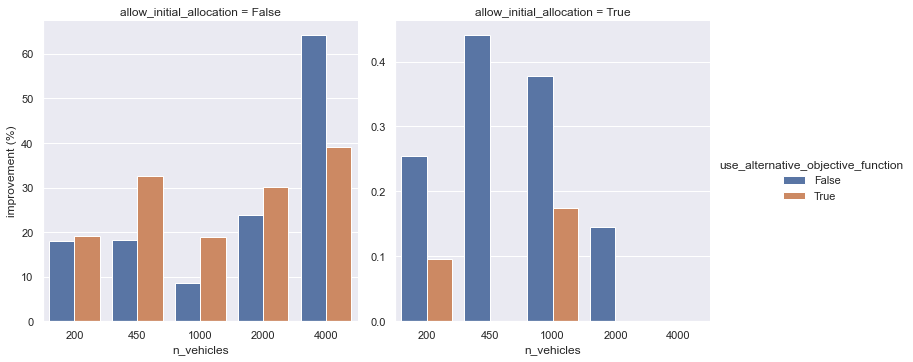

In [161]:
# sns.set_theme(style="darkgrid")

sns.catplot(
    data=results_agg, 
    y="improvement (%)", 
    x="n_vehicles", 
    hue="use_alternative_objective_function", 
    col="allow_initial_allocation",
    kind="bar",
    sharey=False
)
plt.savefig('./figures/compare_results_alt.pdf')
plt.show()

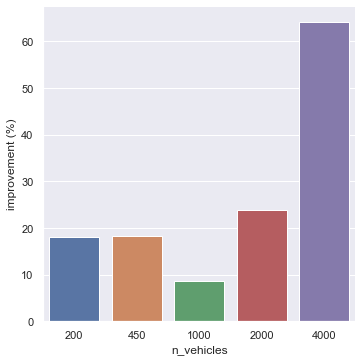

In [187]:
# sns.set_theme(style="darkgrid")

sns.catplot(
    data=results_agg[(results_agg['allow_initial_allocation'] == False) &
                     (results_agg['use_alternative_objective_function'] == False)], 
    y="improvement (%)", 
    x="n_vehicles", 
    kind="bar",
    sharey=False
)
plt.savefig('./figures/results.pdf')
plt.show()

In [164]:
results_agg[results_agg['use_alternative_objective_function'] == False]

n_bicycles  n_mopeds  n_cars  allow_initial_allocation  \
10        2000      1000    1000                      True   
11        1000       500     500                      True   
12         500       250     250                      True   
13         250       100     100                      True   
14         100        50      50                      True   
15        2000      1000    1000                     False   
16        1000       500     500                     False   
17         500       250     250                     False   
18         250       100     100                     False   
19         100        50      50                     False   

    use_alternative_objective_function           opt    opt_no_rel  \
10                               False  29039.085755  29039.085755   
11                               False  40511.386944  40452.636308   
12                               False  33604.853667  33478.365279   
13                               False  20137.816342  20049.439680   
14                               False  12243.167056  12212.090788   
15                               False  22047.266252  13423.733469   
16                               False  34340.184629  27723.733469   
17                               False  31335.051513  28868.694448   
18                               False  21516.808290  18180.946526   
19                               False  13420.112765  11367.263386   

    improvement (%)  improvement (€ or count)  n_vehicles  
10         -0.00000                  -0.00000        4000  
11          0.14523                  58.75064        2000  
12          0.37782                 126.48839        1000  
13          0.44079                  88.37666         450  
14          0.25447                  31.07627         200  
15         64.24094                8623.53278        4000  
16         23.86566                6616.45116        2000  
17          8.54336                2466.35707        1000  
18         18.34812                3335.86176         450  
19         18.05931                2052.84938         200

In [188]:
# print(results_agg[results_agg['use_alternative_objective_function'] == False] \
#       .drop(['n_vehicles', 'use_alternative_objective_function'], axis=1) \
#       .round(2) \
#       .to_latex(index=False))

In [176]:
results_agg[results_agg['use_alternative_objective_function'] == False] \
      [['n_bicycles', 'n_mopeds', 'n_cars', 'allow_initial_allocation',
       'use_alternative_objective_function', 'opt', 'opt_no_rel',
       'improvement (%)', 'improvement (€ or count)', 'n_vehicles']] \
      .round(2) \
      .to_latex()

n_bicycles  n_mopeds  n_cars  allow_initial_allocation  \
10        2000      1000    1000                      True   
11        1000       500     500                      True   
12         500       250     250                      True   
13         250       100     100                      True   
14         100        50      50                      True   
15        2000      1000    1000                     False   
16        1000       500     500                     False   
17         500       250     250                     False   
18         250       100     100                     False   
19         100        50      50                     False   

    use_alternative_objective_function       opt  opt_no_rel  improvement (%)  \
10                               False  29039.09    29039.09            -0.00   
11                               False  40511.39    40452.64             0.15   
12                               False  33604.85    33478.37             0.38   
13                               False  20137.82    20049.44             0.44   
14                               False  12243.17    12212.09             0.25   
15                               False  22047.27    13423.73            64.24   
16                               False  34340.18    27723.73            23.87   
17                               False  31335.05    28868.69             8.54   
18                               False  21516.81    18180.95            18.35   
19                               False  13420.11    11367.26            18.06   

    improvement (€ or count)  n_vehicles  
10                     -0.00        4000  
11                     58.75        2000  
12                    126.49        1000  
13                     88.38         450  
14                     31.08         200  
15                   8623.53        4000  
16                   6616.45        2000  
17                   2466.36        1000  
18                   3335.86         450  
19                   2052.85         200